# Net Promoter Score (NPS)

# Table of contents 

I. Getting data from SQLite. Creating a dataframe. 

II. General information. Interim conclusions.      

III. Data preprocessing.

- Missing values processing.
- Changing the data type.
- Duplicates processing.
- Categorical data processing.
- Numerical data processing.
- Interim conclusions.

IV. Conclusion.

# Getting data from SQLite. Creating a dataframe. 

In [1]:
# libraries import
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
from googletrans import Translator
translator = Translator(service_urls=['translate.googleapis.com'])

In [2]:
# pandas customization
pd.set_option('display.precision', 2)

Displaying tables with borders:

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [4]:
# path
path_to_db = '/datasets/telecomm_csi.db'

In [5]:
# connecting
engine = create_engine(f'sqlite:///{path_to_db}', echo = False)

In this section we need to form a dataframe, add two calculation columns - `is_new` and `nps_group`, as well as adjust the values of the `age_segment`, `traffic_segment`, `lifetime_segment` columns for greater convenience.

**is_new** - this field contains information on whether the client is new. It can be determined by lifetime value. It is calculated from the time of the important event, e.g., the purchase of a SIM card. The client is considered new if the lifetime value is below 365 days.

**nps_group** - this field contains information on the group to which the client score belongs. Clients are usually divided into three groups (based on scores):
- score 9-10 - promoters;
- score 7-8 - passives;
- score 0-6 - detractors.

In [6]:
# query
query = '''SELECT  u.user_id,
                   u.lt_day,
                   u.age,
                   LOWER(u.os_name) AS os_name,
                   LOWER(u.cpe_type_name) AS cpe_type_name,
                   u.nps_score,
                   REPLACE(l.city, 'ё', 'е') AS city,
                   l.country,
                   SUBSTRING(age.title, 4, 5) AS age_segment,
                   SUBSTRING(tr.title, 4, 5) AS traffic_segment,
                   SUBSTRING(lt.title, 4, 5) AS lifetime_segment,
            CASE
                WHEN u.nps_score >= 9 THEN 'promoters'
                WHEN u.nps_score <= 6 THEN 'detractors'
                ELSE 'passives'
            END AS nps_group,
            CASE
                WHEN u.lt_day > 365 THEN 1
                ELSE 0
            END AS is_new,
            CASE
                WHEN u.gender_segment = 0 THEN 'M'
                ELSE 'W'
            END AS gender_segment
            FROM user AS u
            INNER JOIN location AS l ON u.location_id = l.location_id
            INNER JOIN age_segment AS age ON u.age_gr_id = age.age_gr_id
            INNER JOIN traffic_segment AS tr ON u.tr_gr_id = tr.tr_gr_id
            INNER JOIN lifetime_segment AS lt ON u.lt_gr_id = lt.lt_gr_id;'''

In [7]:
# executing query
nps = pd.read_sql(query, engine)

In [8]:
# check
nps.head(5)

,user_id,lt_day,age,os_name,cpe_type_name,nps_score,city,country,age_segment,traffic_segment,lifetime_segment,nps_group,is_new,gender_segment
0,A001A2,2320,45.0,android,smartphone,10,Уфа,Россия,45-54,1-5,36+,promoters,1,W
1,A001WF,2344,53.0,android,smartphone,10,Киров,Россия,45-54,1-5,36+,promoters,1,M
2,A003Q7,467,57.0,android,smartphone,10,Москва,Россия,55-64,20-25,13-24,promoters,1,M
3,A004TB,4190,44.0,ios,smartphone,10,РостовнаДону,Россия,35-44,0.1-1,36+,promoters,1,W
4,A004XT,1163,24.0,android,smartphone,10,Рязань,Россия,16-24,5-10,36+,promoters,1,M


In [9]:
# translation manipulations
d = {}
translations = translator.translate(list(nps.city.unique()), dest='en')
for translation in translations:
    d[translation.origin] = translation.text
nps.replace({'city': d}, inplace=True)
nps['country'].replace({'Россия':'Russia'}, inplace=True)

# General information

In [10]:
# primary data analysis function
def get_info(df):
    '''The function takes a dataframe as an input and provides general information about it: its shape (rows, columns),
    columns data type, number of non-null values (DataFrame.info()), first\last five rows (DataFrame.head()\tail()) and also a
    brief analysis for categorical and numerical data - DataFrame.describe().'''
    percentiles= [.20, .40, .60, .80]
    include=['object', 'float', 'int']
    print(f'Total number of rows: {df.shape[0]}, total number of columns: {df.shape[1]}.')
    print()
    print(df.info())
    display(df.head())
    display(df.tail())
    display(pd.DataFrame(df.describe(percentiles = percentiles, include = include).T))

In [11]:
# applying function
get_info(nps)

Total number of rows: 502493, total number of columns: 14.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502493 entries, 0 to 502492
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           502493 non-null  object 
 1   lt_day            502493 non-null  int64  
 2   age               501939 non-null  float64
 3   os_name           502493 non-null  object 
 4   cpe_type_name     502493 non-null  object 
 5   nps_score         502493 non-null  int64  
 6   city              502493 non-null  object 
 7   country           502493 non-null  object 
 8   age_segment       502493 non-null  object 
 9   traffic_segment   502493 non-null  object 
 10  lifetime_segment  502493 non-null  object 
 11  nps_group         502493 non-null  object 
 12  is_new            502493 non-null  int64  
 13  gender_segment    502493 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 53.7+ 

,user_id,lt_day,age,os_name,cpe_type_name,nps_score,city,country,age_segment,traffic_segment,lifetime_segment,nps_group,is_new,gender_segment
0,A001A2,2320,45.0,android,smartphone,10,Ufa,Russia,45-54,1-5,36+,promoters,1,W
1,A001WF,2344,53.0,android,smartphone,10,Kirov,Russia,45-54,1-5,36+,promoters,1,M
2,A003Q7,467,57.0,android,smartphone,10,Moscow,Russia,55-64,20-25,13-24,promoters,1,M
3,A004TB,4190,44.0,ios,smartphone,10,Rostovna Donu,Russia,35-44,0.1-1,36+,promoters,1,W
4,A004XT,1163,24.0,android,smartphone,10,Ryazan,Russia,16-24,5-10,36+,promoters,1,M


,user_id,lt_day,age,os_name,cpe_type_name,nps_score,city,country,age_segment,traffic_segment,lifetime_segment,nps_group,is_new,gender_segment
502488,ZZZKLD,1249,54.0,android,smartphone,5,Moscow,Russia,45-54,1-5,36+,detractors,1,W
502489,ZZZLWY,129,31.0,android,smartphone,8,Moscow,Russia,25-34,1-5,4-6,passives,0,M
502490,ZZZQ5F,522,36.0,android,smartphone,10,Surgut,Russia,35-44,25-30,13-24,promoters,1,M
502491,ZZZQ8E,2936,37.0,android,smartphone,9,UlanUde,Russia,35-44,65-70,36+,promoters,1,W
502492,ZZZYH0,2471,37.0,ios,smartphone,2,Samara,Russia,35-44,10-15,36+,detractors,1,M


,count,unique,top,freq,mean,std,min,20%,40%,50%,60%,80%,max
user_id,502493,502493,C5MG7S,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lt_day,502493.0,NaN,NaN,NaN,1868.84,1683.7,-21.0,428.0,904.0,1239.0,1623.0,3616.0,9162.0
age,501939.0,NaN,NaN,NaN,39.62,11.19,10.0,30.0,35.0,38.0,41.0,49.0,89.0
os_name,502493,9,android,435981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cpe_type_name,502493,14,smartphone,487959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nps_score,502493.0,NaN,NaN,NaN,7.51,3.02,1.0,5.0,8.0,9.0,10.0,10.0,10.0
city,502493,62,Moscow,66160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,502493,1,Russia,502493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_segment,502493,8,35-44,165933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
traffic_segment,502493,25,1-5,112649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


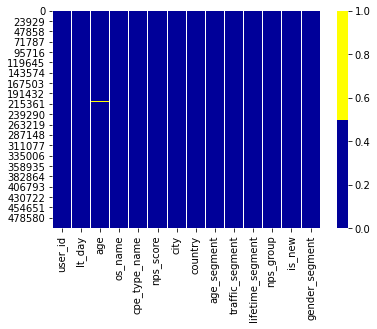

In [12]:
# missing values heatmap (yellow - NaN)
cols = nps.columns
colours = ['#000099', '#ffff00']
sns.heatmap(nps[cols].isnull(), cmap=sns.color_palette(colours));

There dataframe has 14 columns (2 of them - type float64, 3 - int64\int32, 9 - object) and 502493 rows.   

**According to the documentation:**
- `user_id` - unique client ID;
- `lt_day` - lifetime value;
- `age` - age;
- `gender_segment` - gender (W - female, M - male);
- `os_name` - operating system;
- `cpe_type_name` - device type;
- `nps_score` - client score (from 1 to 10);
- `country` - client country;
- `city` - client city;
- `age_segment` - age group;
- `traffic_segment` - group by traffic consumed;
- `lifetime_segment` - lifetime group;
- `is_new` - information on whether the client is new (0 - no, 1 - yes);
- `nps_group` - information on the group to which the client score belongs;

**Brief data analysis:**
- there are no column names issues;
- `user_id` column - all values are unique;
- data type issues: `age` - float64 (int is needed);
- missing values in `age` column; 
- `os_name`, `cpe_type_name`, `city`, `age_segment`, `traffic_segment`, `lifetime_segment` - we'll check columns for duplicates, convert categorical data to lowercase;

## Interim conclusions

Each row of the table contains data about a unique user: score, age, sex, type of device and OS, location, lifetime. Score, age, traffic and lifetime are categorized for easy analysis. 502,493 users have participated. They are all from Russia (66160 of them from Moscow). It is arguable that this amount is sufficient for the analysis.

# Data preprocessing

## Missing values processing

In [13]:
# NaN ratio
# missing values calculation
report = nps.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (100 * report['missing_values'] / nps.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)
report.style.background_gradient('coolwarm')

,missing_values,% of total
user_id,0,0.00
lt_day,0,0.00
age,554,0.11
os_name,0,0.00
cpe_type_name,0,0.00
nps_score,0,0.00
city,0,0.00
country,0,0.00
age_segment,0,0.00
traffic_segment,0,0.00


This percentage of the total can be ignored - we'll drop these rows.

In [14]:
# drop NaN
nps = nps.dropna(axis='index', how='any', subset=['age'])

In [15]:
# check
nps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501939 entries, 0 to 502492
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           501939 non-null  object 
 1   lt_day            501939 non-null  int64  
 2   age               501939 non-null  float64
 3   os_name           501939 non-null  object 
 4   cpe_type_name     501939 non-null  object 
 5   nps_score         501939 non-null  int64  
 6   city              501939 non-null  object 
 7   country           501939 non-null  object 
 8   age_segment       501939 non-null  object 
 9   traffic_segment   501939 non-null  object 
 10  lifetime_segment  501939 non-null  object 
 11  nps_group         501939 non-null  object 
 12  is_new            501939 non-null  int64  
 13  gender_segment    501939 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 57.4+ MB


## Changing the data type

In [16]:
# float64 to int64 replacement
nps['age'] = nps['age'].astype(np.int64)

In [17]:
# check
nps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501939 entries, 0 to 502492
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           501939 non-null  object
 1   lt_day            501939 non-null  int64 
 2   age               501939 non-null  int64 
 3   os_name           501939 non-null  object
 4   cpe_type_name     501939 non-null  object
 5   nps_score         501939 non-null  int64 
 6   city              501939 non-null  object
 7   country           501939 non-null  object
 8   age_segment       501939 non-null  object
 9   traffic_segment   501939 non-null  object
 10  lifetime_segment  501939 non-null  object
 11  nps_group         501939 non-null  object
 12  is_new            501939 non-null  int64 
 13  gender_segment    501939 non-null  object
dtypes: int64(4), object(10)
memory usage: 57.4+ MB


## Duplicates processing

In [18]:
# duplicates ckeck
nps.duplicated().sum()

0

There're no duplicates in the data.

## Cateforical data processing

In [19]:
# unique values and unique groups check
columns = ['os_name', 'cpe_type_name', 'age_segment', 'traffic_segment', 'lifetime_segment', 'nps_group']
for column in columns:
    display(pd.DataFrame(nps[column].value_counts()))

,os_name
android,435569
ios,59914
proprietary,2490
other,2390
windows phone,1297
unknown,133
symbian os,103
bada os,40
windows mobile,3


,cpe_type_name
smartphone,487410
tablet,9270
phone,2530
mobile phone/feature phone,2471
router,196
usb modem,27
unknown,18
modem,7
wlan router,3
network device,3


,age_segment
35-44,165933
25-34,154800
45-54,94269
55-64,43061
16-24,29955
66 +,13236
до 16,685


,traffic_segment
1-5,112527
5-10,84872
10-15,58505
15-20,43333
20-25,33344
0.1-1,27754
25-30,25724
30-35,20769
35-40,16343
40-45,13070


,lifetime_segment
36+,273970
13-24,81971
25-36,61169
7-12,40961
4-6,22425
2,12027
3,9403
1,13


,nps_group
promoters,263981
detractors,153648
passives,84310


## Numerical data processing

In [20]:
# scores check
print('Min score value:', nps.nps_score.min())
print('Max score value:', nps.nps_score.max())

Min score value: 1
Max score value: 10


# Conclusion

The data was processed for a dashboard and presentation.

In [21]:
# data saving
nps.to_csv('nps.csv', index=False)